In [1]:
import os
import numpy as np
import torch as pt
import pandas as pd
import blosum as bl
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from matplotlib import rcParams

import src as sp
from theme import colors

# font parameters
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 12

In [2]:
def max_pred_to_seq(p):
    return ''.join([sp.res3to1[r] for r in sp.std_resnames[:20][pt.argmax(p,dim=1).cpu().numpy()]])

def sequence_identity(seq_ref, seq):
    return np.mean(np.array(list(seq_ref)) == np.array(list(seq)))

def sequence_similarity(seq_ref, seq):
    blm = bl.BLOSUM(62)
    return np.mean(np.array([blm[si][sj] for si,sj in zip(seq_ref,seq)]) > 0)

def max_seq_recovery(p, y):
    msr = pt.mean((p[pt.arange(y.shape[0]), pt.argmax(y, dim=1)] >= 0.5).float())
    mpr = pt.mean(pt.sum((p >= 0.5).float(), dim=1))
    return msr, mpr

In [3]:
# reload precomputed results
data = {}
for fp in glob("results/*.pt"):
    key = os.path.basename(fp).split('.')[0]
    Z = pt.load(fp)
    data[key] = (Z[1:], Z[0])

In [4]:
# analyse all predictions
results = []
for key in data:
    # unpack results
    P, y = data[key]
    
    # get sequences
    seq_ref = max_pred_to_seq(y)
    seqs = [max_pred_to_seq(p) for p in P]
    
    # compute scores
    si = np.array([sequence_identity(seq_ref, seq) for seq in seqs])
    ss = np.array([sequence_similarity(seq_ref, seq) for seq in seqs])
    
    # sequence sampling prediction
    seq_sampling = {
        'mean': max_pred_to_seq(pt.mean(P, dim=0)),
        'median': max_pred_to_seq(pt.median(P, dim=0)[0]),
        'max': max_pred_to_seq(pt.max(P, dim=0)[0]),
        'min': max_pred_to_seq(pt.min(P, dim=0)[0]),
        'argmax': max_pred_to_seq(P[pt.argmax(pt.mean(pt.max(P, dim=2)[0], dim=1))]),
        'gmean': max_pred_to_seq(pt.exp(pt.mean(pt.log(P), dim=0))),
    }

    # maximum sequence recovery with different sampling methods
    msr = pt.tensor([max_seq_recovery(p,y) for p in P]).numpy()
    msr_sampling = {
        'mean': pt.tensor(max_seq_recovery(pt.mean(P, dim=0), y)).numpy(),
        'median': pt.tensor(max_seq_recovery(pt.median(P, dim=0)[0], y)).numpy(),
        'argmax': pt.tensor(max_seq_recovery(P[pt.argmax(pt.mean(pt.max(P, dim=2)[0], dim=1))], y)).numpy(),
        'gmean': pt.tensor(max_seq_recovery(pt.exp(pt.mean(pt.log(P), dim=0)), y)).numpy(),
    }
    
    # store results
    results.append({
        'pdbid': key.split(':')[0],
        'mdid': key.split(':')[1],
        'ref_si': si[0],
        'ref_ss': ss[0],
        'mean_si': np.mean(si),
        'mean_ss': np.mean(ss),
        'max_si': np.max(si),
        'max_ss': np.max(ss),
        'ref_msr': msr[0,0],
        'ref_sm': msr[0,1],
        'mean_msr': np.mean(msr, axis=0)[0],
        'mean_sm': np.mean(msr, axis=0)[1],
    })
    
    for name in seq_sampling:
        results[-1]['{}_p_si'.format(name)] = sequence_identity(seq_ref, seq_sampling[name])
        results[-1]['{}_p_ss'.format(name)] = sequence_similarity(seq_ref, seq_sampling[name])

    for name in msr_sampling:
        results[-1]['{}_p_msr'.format(name)] = msr_sampling[name][0]
        results[-1]['{}_p_sm'.format(name)] = msr_sampling[name][1]

# pack results
df = pd.DataFrame(results)

In [5]:
df.round(3)

,pdbid,mdid,ref_si,ref_ss,mean_si,mean_ss,max_si,max_ss,ref_msr,ref_sm,...,gmean_p_si,gmean_p_ss,mean_p_msr,mean_p_sm,median_p_msr,median_p_sm,argmax_p_msr,argmax_p_sm,gmean_p_msr,gmean_p_sm
0,1R0R,C,0.680,0.815,0.508,0.669,0.680,0.815,0.905,2.834,...,0.618,0.772,0.895,3.012,0.892,3.163,0.905,2.834,0.855,2.434
1,2I25,uL,0.690,0.860,0.505,0.681,0.690,0.860,0.946,3.186,...,0.651,0.798,0.946,3.194,0.946,3.240,0.946,3.186,0.891,2.636
2,2OOB,bR,0.488,0.634,0.396,0.606,0.585,0.756,0.854,4.293,...,0.439,0.707,0.805,3.902,0.805,4.098,0.780,4.122,0.756,3.122
3,1GPW,C,0.534,0.724,0.434,0.640,0.534,0.724,0.865,3.892,...,0.556,0.764,0.857,3.428,0.868,3.554,0.865,3.892,0.801,2.740
4,2UUY,bR,0.650,0.771,0.458,0.625,0.650,0.771,0.892,3.049,...,0.587,0.744,0.865,3.359,0.865,3.448,0.892,3.049,0.798,2.673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1CLV,uL,0.438,0.531,0.479,0.562,0.688,0.750,0.781,5.156,...,0.562,0.625,0.781,3.406,0.781,3.562,0.750,3.156,0.656,2.594
96,1ZHH,bL,0.402,0.594,0.328,0.525,0.402,0.598,0.781,4.288,...,0.425,0.589,0.758,3.799,0.772,3.968,0.676,4.311,0.662,3.064
97,3F1P,bL,0.405,0.640,0.334,0.569,0.432,0.685,0.793,4.063,...,0.495,0.721,0.784,3.793,0.775,3.910,0.793,4.063,0.730,2.973
98,2HQS,C,0.595,0.759,0.429,0.598,0.595,0.759,0.887,3.269,...,0.557,0.706,0.846,3.464,0.846,3.634,0.887,3.269,0.785,2.739


In [6]:
df.mean().round(3)

/tmp/ipykernel_9006/731755988.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.mean().round(3)


ref_si          0.530
ref_ss          0.693
mean_si         0.418
mean_ss         0.593
max_si          0.555
max_ss          0.721
ref_msr         0.844
ref_sm          3.786
mean_msr        0.779
mean_sm         4.396
mean_p_si       0.537
mean_p_ss       0.705
median_p_si     0.531
median_p_ss     0.695
max_p_si        0.435
max_p_ss        0.546
min_p_si        0.468
min_p_ss        0.678
argmax_p_si     0.516
argmax_p_ss     0.684
gmean_p_si      0.541
gmean_p_ss      0.713
mean_p_msr      0.834
mean_p_sm       3.514
median_p_msr    0.838
median_p_sm     3.665
argmax_p_msr    0.824
argmax_p_sm     3.634
gmean_p_msr     0.774
gmean_p_sm      2.801
dtype: float64

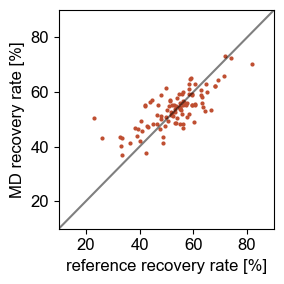

In [7]:
x = 1e2*df['ref_si'].values
y = 1e2*df['mean_p_si'].values

plt.figure(figsize=(3,3))
plt.plot(x, y, '.', ms=4.0, color=colors[0])
plt.plot([0,100],[0,100], 'k-', alpha=0.5)
plt.xlim(10, 90)
plt.ylim(10, 90)
plt.xlabel('reference recovery rate [%]')
plt.ylabel('MD recovery rate [%]')
plt.tight_layout()
plt.savefig("graphs/ref_v_md_recovery_rate.svg")
plt.show()

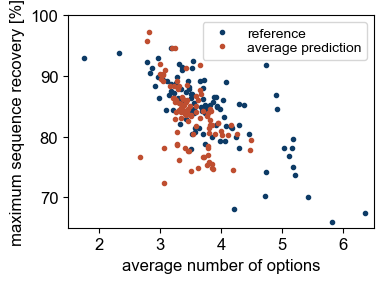

In [11]:
V0 = df[['ref_sm', 'ref_msr']].values
V1 = df[['mean_p_sm', 'mean_p_msr']].values

#plt.figure(figsize=(3.1,3))
plt.figure(figsize=(4,3))
plt.plot(V0[:,0], 1e2*V0[:,1], '.', ms=6.0, color=colors[1], label="reference")
plt.plot(V1[:,0], 1e2*V1[:,1], '.', ms=6.0, color=colors[0], label="average prediction")
plt.xlim(1.5, 6.5)
plt.ylim(65, 100)
plt.legend(loc='upper right', prop={'size': 10}, labelspacing=0.1)
plt.xlabel('average number of options')
plt.ylabel('maximum sequence recovery [%]')
plt.tight_layout()
plt.savefig("graphs/max_recovery_md.svg")
plt.show()

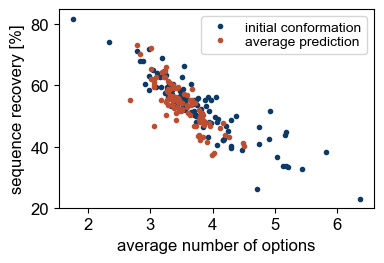

In [12]:
V0 = df[['ref_sm', 'ref_si']].values
V1 = df[['mean_p_sm', 'mean_p_si']].values

#plt.figure(figsize=(3,3))
plt.figure(figsize=(4,2.8))
plt.plot(V0[:,0], 1e2*V0[:,1], '.', ms=6.0, color=colors[1], label="initial conformation")
plt.plot(V1[:,0], 1e2*V1[:,1], '.', ms=6.0, color=colors[0], label="average prediction")
#plt.xlim(1.5, 6.5)
plt.ylim(20, 85)
plt.legend(loc='upper right', prop={'size': 10}, labelspacing=0.1)
plt.xlabel('average number of options')
plt.ylabel('sequence recovery [%]')
plt.tight_layout()
plt.savefig("graphs/recovery_md.svg")
plt.show()

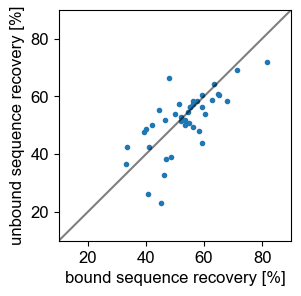

In [10]:
xR = 1e2*np.array([df[(df['pdbid'] == pdbid) & (df['mdid'] == 'bR')]['ref_si'].values for pdbid in df['pdbid'].unique()]).ravel()
yR = 1e2*np.array([df[(df['pdbid'] == pdbid) & (df['mdid'] == 'uR')]['ref_si'].values for pdbid in df['pdbid'].unique()]).ravel()
xL = 1e2*np.array([df[(df['pdbid'] == pdbid) & (df['mdid'] == 'bL')]['ref_si'].values for pdbid in df['pdbid'].unique()]).ravel()
yL = 1e2*np.array([df[(df['pdbid'] == pdbid) & (df['mdid'] == 'uL')]['ref_si'].values for pdbid in df['pdbid'].unique()]).ravel()
x = np.concatenate([xR,xL])
y = np.concatenate([yR,yL])

plt.figure(figsize=(3,3))
plt.plot(x,y,'.')
plt.plot([0,100],[0,100], 'k-', alpha=0.5)
plt.xlim(10, 90)
plt.ylim(10, 90)
plt.xlabel('bound sequence recovery [%]')
plt.ylabel('unbound sequence recovery [%]')
plt.show()